# Example with the dummy data

### Imports


The first thing we need to do is import some essential stuff. Theses also have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Now to the fun stuff, we import our module!

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
%load_ext autoreload
%autoreload 2

## Create dummy data object

### Random case

In [56]:
#Create dates for data generation
data_begin = datetime.datetime(2020,3,11)
data_end = datetime.datetime(2020,5,3)

#We choose some two easy change points for the initial
change_points = [[datetime.datetime(2020,3,10), 0.4],
                 [datetime.datetime(2020,3,21), 0.2],
                 [datetime.datetime(2020,3,31), 0.15]]

# Create dummy data object
dd = cov19.dummy_data.DummyData(data_begin,
                                data_end,
                                change_points=change_points,
                                noise=True,
                                seed=0,
                                I_initial=10)

### Initials equal to a real case (WIP)

In [115]:
data_begin = datetime.datetime(2020, 2, 1)
data_end = datetime.datetime(2020, 5, 4)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

initials = {
    "lambda_initial" : 0.35,
    "change_points" : [[prior_date_mild_dist_begin,0.25],
                    [prior_date_strong_dist_begin,0.15]],
    "I_initial" : 32,
    "S_initial" : 86e6,
    "weekend_factor" : 0.3,
    "case_delay" : 6,
}

In [116]:
dd = cov19.dummy_data.DummyData(data_begin,data_end,noise=False,**initials,seed=4)

We can look at our initially generated values and tweak them by the attribute `dd.initials`. Our seed for the random number generation can be retrieved with `dd.seed`.

In [117]:
for key in dd.initials:
    print(f"{key}: {dd.initials[key]}")
print(f"Seed: {dd.seed}")

S_initial: 86000000.0
I_initial: 32
R_initial: 0
lambda_initial: 0.35
change_points: [[datetime.datetime(2020, 3, 9, 0, 0), 0.25], [datetime.datetime(2020, 3, 16, 0, 0), 0.15]]
noise_factor: 1e-05
offset_sunday: 1
weekend_factor: 0.3
case_delay: 6
Seed: 4


If we are happy with the initial values we can generate our dummy data set.

In [118]:
data = dd.generate()

The generated data is also accesible by the attribute `dd.data` as pandas dataframe.

## Preliminary plot of the generated data 

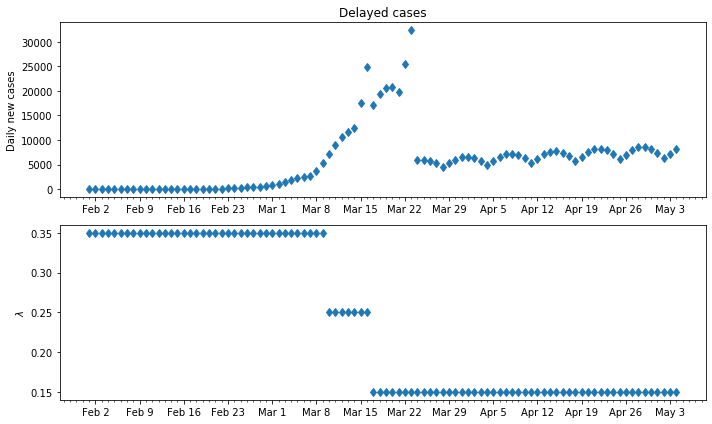

In [119]:
#Create figure
fig, ax = plt.subplots(2,1,figsize=(10,6))

#Plot dummy data
cov19.plot._timeseries(data.index, data["new_cases"], ax[0],lw=0)
cov19.plot._timeseries(data.index, data["lambda_t"], ax[1],lw=0)

#Set labels
ax[0].set_ylabel("Daily new cases")
ax[1].set_ylabel(f"$\lambda$")
ax[0].set_title("Delayed cases")
#ax[1].set_title("NOT delayed lambda")

#Format x axis
cov19.plot._format_date_xticks(ax[0])
cov19.plot._format_date_xticks(ax[1])
delta = datetime.timedelta(days=2)


plt.tight_layout()

### Create the model

In [120]:
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

#Get priors for changepoints from dummy data
change_points = []
for cp in dd.initials["change_points"]:
    change_points.append(dict(pr_mean_date_transient = cp[0],
         pr_sigma_date_transient = 6,
         pr_median_lambda = cp[1],
         pr_sigma_lambda = 2))

In [121]:
params_model = dict(new_cases_obs = data["new_cases"],
                    data_begin = data.index[0],
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


### MCMC sampling

In [ ]:
trace = pm.sample(model=model, tune=1500, draws=1500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 923.89:  11%|█         | 21699/200000 [01:08<09:20, 318.10it/s] 
Convergence achieved at 21700
INFO     [pymc3.variational.inference] Convergence achieved at 21700
Interrupted at 21,699 [10%]: Average Loss = 1,133.9
INFO     [pymc3.variational.inference] Interrupted at 21,699 [10%]: Average Loss = 1,133.9
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulati

### Plotting the trace

In [24]:
trace.varnames

['lambda_0_log',
 'lambda_1_log',
 'lambda_2_log',
 'lambda_3_log',
 'transient_day_1',
 'transient_day_2',
 'transient_day_3',
 'transient_len_1_log',
 'transient_len_2_log',
 'transient_len_3_log',
 'mu_log__',
 'I_begin_log__',
 'delay_log',
 'weekend_factor',
 'offset_modulation_rad_circular__',
 'sigma_obs_log__',
 'lambda_0',
 'lambda_1',
 'lambda_2',
 'lambda_3',
 'transient_len_1',
 'transient_len_2',
 'transient_len_3',
 'lambda_t',
 'mu',
 'I_begin',
 'new_I_t',
 'delay',
 'new_cases_raw',
 'offset_modulation_rad',
 'offset_modulation',
 'new_cases',
 'sigma_obs']

Add the model and forecast to the already generated axes for the dummy data (see above).

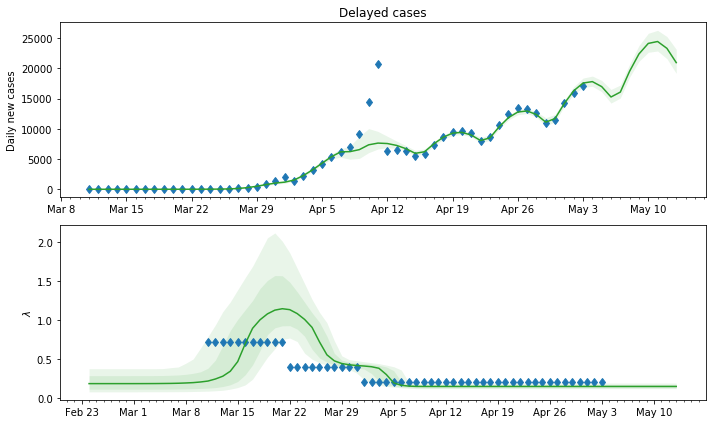

In [56]:
# New cases
y = trace["new_cases"][:,:]
x = pd.date_range(model.data_begin, model.fcast_end)
cov19.plot._timeseries(x,y,ax[0],what="model", draw_ci_95=True)


# lambda t
y = trace["lambda_t"][:,:]
x = pd.date_range(model.sim_begin, model.fcast_end)
cov19.plot._timeseries(x,y,ax[1],what="model", draw_ci_75=True)

fig

In [60]:
y,x = cov19.plot._get_array_from_trace_via_date(model,trace,"new_cases",model.data_begin, model.fcast_end)

IndexError: too many indices for array

What is the lambda doing 

We can also compare our changepoints from the dummy data with the changepoints from the trace.

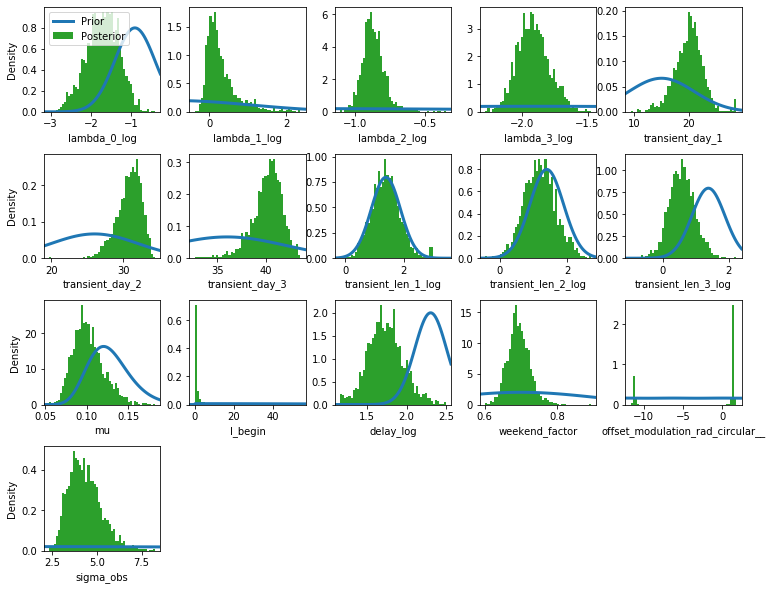

In [57]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


In [61]:
np.exp(trace["delay_log"].mean())

5.684900968602497